In [1]:
import matplotlib.pyplot as plt
import cv2
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator #이미지 데이터 증폭
(X_data, y_data), (tt_x, tt_y) = cifar10.load_data()

170508288/170498071 [==============================] - 19s 0us/step


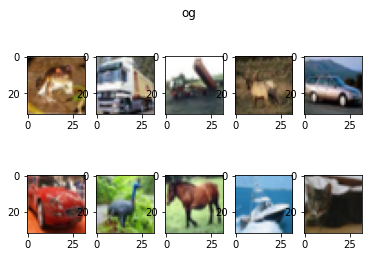

In [3]:
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_data[i])
plt.suptitle('og')
plt.show()

In [4]:
n_data_m = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
g = n_data_m.flow(X_data,y_data,shuffle=False)
X_batch, y_batch = g.next()


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


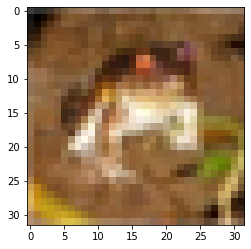

In [7]:
plt.imshow(X_batch[0].astype('uint8'))
#연산을 하고 나면 대부분 실수로 바껴있다. 이미지를 처리할거면 데이터를 양의 정수로 바꿔주는 것이 좋다.

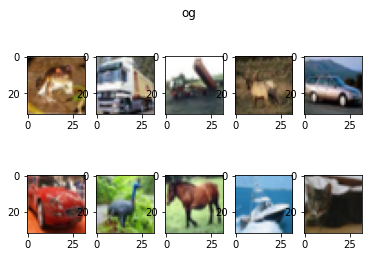

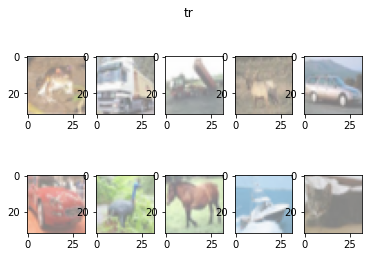

In [8]:
X_batch *= 127.0 / max(abs(X_batch.min()),X_batch.max()) #255의 절반값. 
X_batch += 127
X_batch = X_batch.astype('uint8')

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_data[i])
plt.suptitle('og')
plt.show()

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_batch[i])
plt.suptitle('tr')
plt.show()

In [9]:
X_data.shape

(50000, 32, 32, 3)

In [10]:
s_t_x = X_data[:300]
s_t_y = y_data[:300]
s_tt_x = tt_x[:100]
s_tt_y = tt_y[:100]

In [14]:
datagen = ImageDataGenerator(zca_whitening=True) #백색화
datagen.fit(s_t_x)
g = datagen.flow(s_t_x, s_t_y, shuffle = False)
s_X_batch, s_y_batch = g.next()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [15]:
s_X_batch *= 127.0 / max(abs(s_X_batch.min()),s_X_batch.max()) #255의 절반값. 
s_X_batch += 127
s_X_batch = s_X_batch.astype('uint8')

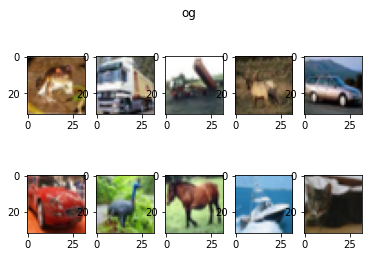

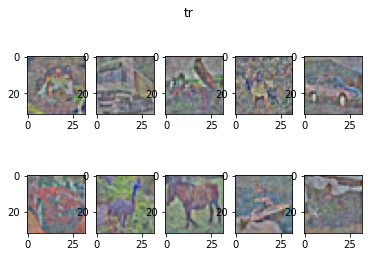

In [16]:
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_data[i])
plt.suptitle('og')
plt.show()

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(s_X_batch[i])
plt.suptitle('tr')
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Activation, Input, Dropout
from keras.models import Sequential, load_model, Model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10


In [2]:
(X_data, y_data), (tt_x, tt_y) = cifar10.load_data()

In [3]:
X_data.shape

(50000, 32, 32, 3)

In [4]:
y_data = to_categorical(y_data)
tt_y = to_categorical(tt_y)

In [5]:
from keras.applications.vgg16 import VGG16
#Sequential을 쓰지 않고 일일이 값을 넣고 뽑아보는 과정
#이미 학습된 모델인 vggnet을 써보려 한다.
input_tensor = Input(shape=(32,32,3))
vgg16 = VGG16(include_top=False, weights='imagenet',input_tensor=input_tensor)

In [6]:
t_m = vgg16.output
t_m = Flatten(input_shape = vgg16.output_shape[1:])(t_m) #사진 개수를 나타내는 차원은 제외
t_m = Dense(256, activation='sigmoid')(t_m)
t_m = Dropout(0.5)(t_m)
t_m = Dense(10, activation = 'softmax')(t_m)

In [7]:
m = Model(inputs = vgg16.input, outputs=t_m)

In [8]:
len(m.layers)
#총 레이어층이 23개인데 위에선 4개만 추가했다. 따라서 원래 있던 vggnet의 레이어는 19개.
#이미 학습되어있던 19개의 레이어는 학습하지 않으려 한다.(가중치를 바꾸지 않게 하기 위해)

23

In [9]:
for layer in m.layers[:19]:
    layer.trainable = False

In [10]:
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [11]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

In [12]:
m.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-4,momentum=0.9),metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
hy = m.fit(X_data, y_data, validation_data = [tt_x, tt_y], epochs = 3, batch_size = 32)

Epoch 1/3
1563/1563 [==============================] - 663s 423ms/step - loss: 2.3339 - accuracy: 0.2047 - val_loss: 1.7807 - val_accuracy: 0.3883
Epoch 2/3
1563/1563 [==============================] - 656s 420ms/step - loss: 1.8996 - accuracy: 0.3325 - val_loss: 1.6113 - val_accuracy: 0.4438
Epoch 3/3
1563/1563 [==============================] - 611s 391ms/step - loss: 1.7393 - accuracy: 0.3872 - val_loss: 1.5272 - val_accuracy: 0.4750


In [15]:
sc = m.evaluate(tt_x,tt_y)

 30/313 [=>............................] - ETA: 1:30 - loss: 1.5452 - accuracy: 0.4719

KeyboardInterrupt: ignored

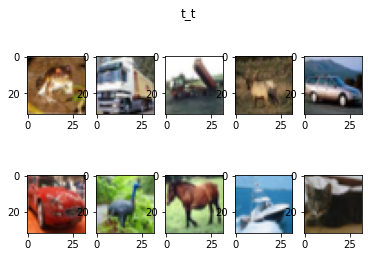

In [14]:
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_data[i])
plt.suptitle('t_t')
plt.show()

In [16]:
t_t=np.argmax(tt_y[:10], axis = 1)

In [17]:
#가장 큰 값의 인덱스가 나옴
pred = np.argmax(m.predict(tt_x[:10]), axis=1)
print(t_t, pred, sep = '\n')

[3 8 8 0 6 6 1 6 3 1]
[6 8 9 8 6 6 1 6 6 3]


15개 학습 안함

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Activation, Input, Dropout
from keras.models import Sequential, load_model, Model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
#데이터 로드, 전처리
(X_data, y_data), (tt_x, tt_y) = cifar10.load_data()
y_data = to_categorical(y_data)
tt_y = to_categorical(tt_y)

170508288/170498071 [==============================] - 4s 0us/step


In [2]:
#사전학습된 모델 로드, 퓨어 트레이닝
input_tensor = Input(shape=(32,32,3))
vgg16 = VGG16(include_top=False, weights='imagenet',input_tensor=input_tensor)

#부분모델 생성
t_m = vgg16.output
t_m = Flatten(input_shape = vgg16.output_shape[1:])(t_m) #사진 개수를 나타내는 차원은 제외
t_m = Dense(256, activation='sigmoid')(t_m)
t_m = Dropout(0.5)(t_m)
t_m = Dense(10, activation = 'softmax')(t_m)

58900480/58889256 [==============================] - 0s 0us/step


In [11]:
del m

NameError: ignored

In [12]:
#모델 완성
m = Model(inputs = vgg16.input, outputs=t_m)

In [13]:
#학습 레이어 결정
#원래 만들어진 모델의 가중치를 변경하지 않도록 trainable을 몇 False로 바꿈.
#근데 종단에 있는 컨볼루션 층만 내가 넣는 데이터에 더 잘 학습하도록 학습 가능하도록 놔둠
for layer in m.layers[:15]:
    layer.trainable = False
#학습규칙 설정
m.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-4,momentum=0.9),metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [14]:
#학습
hy = m.fit(X_data, y_data, validation_data = [tt_x, tt_y], epochs = 20, batch_size = 32)

Epoch 1/20
1563/1563 [==============================] - 28s 17ms/step - loss: 0.5206 - accuracy: 0.8302 - val_loss: 0.6930 - val_accuracy: 0.7679
Epoch 2/20
1563/1563 [==============================] - 27s 18ms/step - loss: 0.4800 - accuracy: 0.8432 - val_loss: 0.6826 - val_accuracy: 0.7712
Epoch 3/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.4424 - accuracy: 0.8556 - val_loss: 0.7000 - val_accuracy: 0.7659
Epoch 4/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.4080 - accuracy: 0.8680 - val_loss: 0.6860 - val_accuracy: 0.7751
Epoch 5/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.3744 - accuracy: 0.8802 - val_loss: 0.6974 - val_accuracy: 0.7746
Epoch 6/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.3393 - accuracy: 0.8919 - val_loss: 0.7023 - val_accuracy: 0.7739
Epoch 7/20
1563/1563 [==============================] - 27s 17ms/step - loss: 0.3028 - accuracy: 0.9036 - val_loss: 0.7300 -

In [ ]:
sc = m.evaluate(tt_x,tt_y)

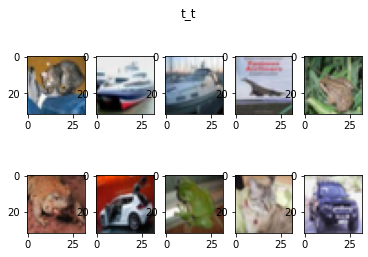

In [7]:
#검증
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(tt_x[i])
plt.suptitle('t_t')
plt.show()

In [8]:
t_t=np.argmax(tt_y[:10], axis = 1)

In [9]:
#가장 큰 값의 인덱스가 나옴
pred = np.argmax(m.predict(tt_x[:10]), axis=1)
print(t_t, pred, sep = '\n')

[3 8 8 0 6 6 1 6 3 1]
[3 8 8 0 6 6 3 6 3 1]
